<a href="https://colab.research.google.com/github/MohammedAlbaqerH/Code-Lab-ML/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
style transfer

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

## Download vgg19 model
vgg19 is used to extract featurs from both style and contant images

In [ ]:
vgg19_model = vgg19.VGG19(include_top=False)

In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Make model
this function will be used to constract a model that return the output of first conv-layer from each block.

In [ ]:
def make_model(layers):
  '''this function will constarct the model '''
  vgg19_model.trainable = False
  output = [vgg19_model.get_layer(layer).output for layer in layers]
  return tf.keras.Model(vgg19_model.input, output)

layers  = ['input_1','block1_conv1','block2_conv1','block3_conv1','block4_conv1', 'block5_conv1'] 
model = make_model(layers)

## Calculate loss 

In [ ]:
def gram_matrix(sty_featur):
  """calculate gram matirx"""
  batch_size, high, width, chanl =  sty_featur.shape
  m = tf.reshape(sty_featur, (high*width,chanl ))
  gram = tf.matmul(sty_featur, sty_featur, transpose_a=True)
  n = gram.shape[0]
  return gram

In [ ]:
def style_loss(org_featur, gen_featur):
  """calculate the style image's loss"""
  org_gram = gram_matrix(org_featur)
  gen_gram = gram_matrix(gen_featur)

  loss = tf.reduce_mean((org_gram - gen_gram)**2)
  return loss

In [ ]:
def contant_loss(org_featur, gen_featur):
  """calculate the contant image's loss"""
  contant_loss = tf.reduce_mean((org_featur - gen_featur)**2)
  return contant_loss/len(layers)

## Define the Hyper parameters define the trainer function

In [ ]:
#hyper parameters
beta = 1e-4
alpha = 1e3
learning_rate = 0.5
epochs = 800

In [ ]:
#define the optimizer
optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
def train(contant_image, style_image, alpha, beta, epochs = 3):
  genrated_image = tf.Variable(tf.identity(contant_image))

  style_featurs = model(style_image)
  contant_featurs = model(contant_image)
  for i in tqdm(range(epochs)):
    with tf.GradientTape() as g:
      with tf.device('/gpu:0'):
        g.watch(genrated_image)

        genrated_featurs = model(genrated_image)
        
        s_loss = c_loss = 0
        for gen_featur, cont_featur, sty_featur in zip(genrated_featurs, contant_featurs,
                                                    style_featurs):
          # calculate loss
          s_loss += style_loss(sty_featur, gen_featur)
          c_loss += contant_loss(gen_featur, cont_featur)

        total_loss = alpha*c_loss + beta*s_loss
        #calculate gradient 
        grad = g.gradient(total_loss, genrated_image)
        #use gradient to update genrated_image via the optimizer
        optimizer.apply_gradients([(grad, genrated_image)])
  return genrated_image

        
        

## Define the laod and show Image functions

In [ ]:
def load_image(path, high = 256, width = 256, orginal_rate = False):
  """ this function should take the path and return the pre-precesed image"""
  img = tf.io.read_file(path)
  img = tf.io.decode_image(img)
  rate = img.shape[1]/img.shape[0]
  
  if orginal_rate: # the orginal_rate true, then you can only control the high.
    width = int(rate*high)
    img = tf.image.resize(img, (high, width))
    
  else:
    img = tf.image.resize(img, (high,width))


  img = tf.expand_dims(img, axis=0)
  return img, width


In [ ]:
def show_image(contant, style, result):
  """ this function show the three images (contant, style, result)
  in 1x3 grid"""
  plt.figure(figsize=(10, 3))

  plt.subplot(1,3,1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np.array(contant[0,:],np.int32))
  plt.xlabel('contant')

  plt.subplot(1,3,2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np.array(style[0,:],np.int32))
  plt.xlabel('style')

  plt.subplot(1,3,3)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np.array(result[0,:],np.int32))
  plt.xlabel('style transfer')

  plt.subplots_adjust(wspace=0.01, hspace=0)


## Define Stylize funtion 
this function will compine the load image and train finctions in one funtion

In [ ]:
def stylize(contant, style, alpha, beta, hight, epochs = 800):
  """ this function will take contant and style paths as an input and return genrated iamge, contant image
  style image"""
  contant_image, width = load_image(contant,high=hight, orginal_rate = True)
  style_image, _ = load_image(style, width=width, orginal_rate = False)
  genrated_image = train(contant_image, style_image, alpha=alpha,beta=beta, epochs=epochs)
  return genrated_image, contant_image, style_image

## Train the images

In [ ]:
#these list will contain the output images to show them later 
style_images = []
contant_images = []
gen_images = []

In next block of code the model train three images with style.
the `final project pic` folder has this structure:

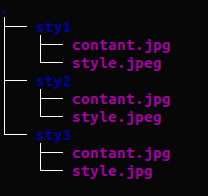





In [ ]:
for i in os.walk('/content/drive/MyDrive/final project pic'):
  if len(i[2]) != 0: ##First elemant in os.walk is the root folder, so this condtion will ignore it
    print('trian style at:', i[0])
    contant_path = i[0] + '/' + i[2][0] #because of the alphabetical order the contant_path takes the index 0
    style_path = i[0] + '/' + i[2][1] # and the style_path takes the index 1
    genrated_image, contant_image, style_image = stylize(contant_path, style_path, 
                                                         alpha=alpha, beta=beta, hight=256)
    genrated_image.assign(tf.clip_by_value(genrated_image, 0, 255)) # clip the output to the range 0-255
    # add the outputs to the list of outputs
    style_images.append(style_image)
    contant_images.append(contant_image)
    gen_images.append(genrated_image)



trian style at: /content/drive/MyDrive/final project pic/sty3



trian style at: /content/drive/MyDrive/final project pic/sty2



trian style at: /content/drive/MyDrive/final project pic/sty1


## Show the outputs

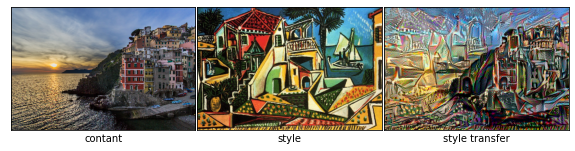

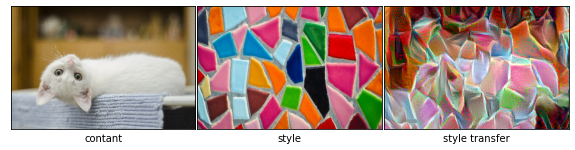

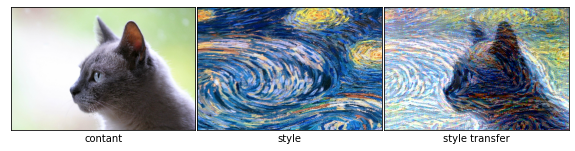

In [ ]:
for i in range(len(style_images)):
  show_image(contant_images[i], style_images[i], gen_images[i]) 